# Autoencoder for dimensionality reduction in the FC data

## 0. Import library

In [1]:
import numpy as np
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

2023-08-18 17:39:44.579002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Load the data

In [2]:
# load all data
# subject 50059 has some problem with the data, so delete this subject entirely
task_list = ['bart','bht','scap','stopsignal']
X_all = empty_array = np.empty((0, 16384))
y_all = empty_array = np.empty((0,1))
for i in os.listdir('processed_data'):
    if i.startswith("sub") & ~i.endswith('50059.csv'):
        sub_data = pd.read_csv('processed_data/'+i, index_col=[0])
        for task in task_list:
            try:
                this_x = sub_data[sub_data['task'] == task]
                X_all = np.vstack((X_all, np.asarray(this_x.correlation).reshape((1,16384)))) 
                y_all = np.vstack((y_all,task))
            except:
                print(i + ': ' + task) 
            
print(X_all.shape)
print(y_all.shape)

(648, 16384)
(648, 1)


In [4]:
# define train and test set
# Split data into training and testing sets, stratified by y
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
print(X_train.shape)
print(X_test.shape)

(518, 16384)
(130, 16384)


## 2.1 Build the autoencoder

In [5]:
# build an autoencoder
# 16384 -> 4096 -> -> 1024 -> 512 -> 128 
# Define the dimensions
input_dim = X_train.shape[1]
latent_dim = 32

# Build the autoencoder model
input_layer = Input(shape=(input_dim,))
encoder1 = Dense(4096, activation='relu')(input_layer)
encoder2 = Dense(1024, activation='relu')(encoder1)
encoder3 = Dense(256, activation='relu')(encoder2)

latent = Dense(latent_dim, activation='relu')(encoder3)

decoder1 = Dense(256, activation='relu')(latent)
decoder2 = Dense(1024, activation='relu')(decoder1)
decoder3 = Dense(4096, activation='relu')(decoder2)
decoder_out = Dense(input_dim, activation='linear')(decoder3)

autoencoder = Model(inputs = input_layer, outputs = decoder_out)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Print the model info
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16384)]           0         
                                                                 
 dense (Dense)               (None, 4096)              67112960  
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 32)                8224      
                                                                 
 dense_4 (Dense)             (None, 256)               8448      
                                                                 
 dense_5 (Dense)             (None, 1024)              263168

## 2.2 Train the Autoencoder

In [6]:
# Train the autoencoder
# save model checkpoint
checkpoint_path = "AE_checkpoint/AE_checkpoint_{epoch:02d}.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=False, save_weights_only=False)
history = History()
autoencoder.fit(X_train, X_train, # from x_train to x_train
                epochs=40, # number of times the entire dataset will be iterated through during training
                batch_size=50, # the number of samples that will be used in each update of the model's weights.
                shuffle=True, #  the training data will be shuffled before each epoch
                validation_data=(X_test, X_test),
                   callbacks=[history, model_checkpoint])

# Access the recorded loss values
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

Epoch 1/40
11/11 [==============================] - 54s 4s/step - loss: 0.0709 - val_loss: 0.0571
Epoch 2/40
11/11 [==============================] - 45s 4s/step - loss: 0.0499 - val_loss: 0.0470
Epoch 3/40
11/11 [==============================] - 42s 4s/step - loss: 0.0475 - val_loss: 0.0463
Epoch 4/40
11/11 [==============================] - 46s 4s/step - loss: 0.0463 - val_loss: 0.0441
Epoch 5/40
11/11 [==============================] - 44s 4s/step - loss: 0.0444 - val_loss: 0.0436
Epoch 6/40
11/11 [==============================] - 42s 4s/step - loss: 0.0440 - val_loss: 0.0436
Epoch 7/40
11/11 [==============================] - 41s 4s/step - loss: 0.0438 - val_loss: 0.0433
Epoch 8/40
11/11 [==============================] - 41s 4s/step - loss: 0.0434 - val_loss: 0.0427
Epoch 9/40
11/11 [==============================] - 40s 4s/step - loss: 0.0425 - val_loss: 0.0420
Epoch 10/40
11/11 [==============================] - 43s 4s/step - loss: 0.0419 - val_loss: 0.0419
Epoch 11/40
11/11 [

## 2.3 Select an appropriate epoch based on the loss and val_loss curve

### Display the loss curves

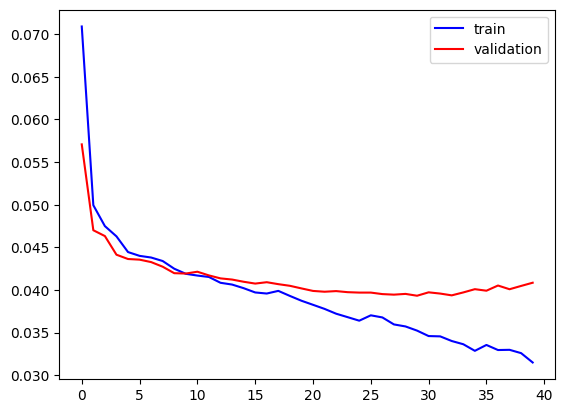

In [7]:
# visualize train and validation loss
plt.plot(loss_values, c='b',label = 'train')
plt.plot(val_loss_values, c = 'r', label = 'validation')
plt.legend()
plt.show()

### Load the best model and make predictions

In [4]:
# predict using a specific model
epoch_to_load = 30  # Specify the epoch you want to load
selected_decoder = load_model(f"AE_checkpoint/AE_checkpoint_{epoch_to_load:02d}.h5")
decoded_matrix = selected_decoder.predict(X_all)

21/21 [==============================] - 1s 59ms/step


In [7]:
# organize using the network template
from nilearn import datasets
dim = 128
res = 2
difumo = datasets.fetch_atlas_difumo(
    dimension=dim, resolution_mm=res, legacy_format=False
)
label_difumo =difumo.labels
label_difumo.loc[label_difumo['yeo_networks7'] == 'No network found', 'yeo_networks7'] = 'Zero'
sorted_indices = label_difumo.sort_values(by=['yeo_networks7','yeo_networks17','difumo_names']).index


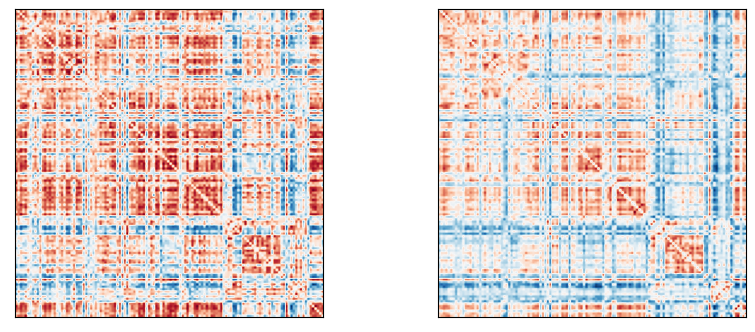

In [17]:
# save one comparison image
# some good examples: 199, 
i = 93
# transform the matrix
mat_original = X_all[i].reshape(128, 128)
mat_decoded = decoded_matrix[i].reshape(128,128)
np.fill_diagonal(mat_original, 0)
np.fill_diagonal(mat_decoded, 0)
mat_original_reorder = mat_original[sorted_indices][:, sorted_indices]
mat_decoded_reorder = mat_decoded[sorted_indices][:, sorted_indices]

# Display original FC
plt.figure(figsize=(10,4))
ax = plt.subplot(1, 2, 1)
ax.imshow(mat_original_reorder,cmap = 'RdBu_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Display reconstructed images
ax = plt.subplot(1, 2, 2)
plt.imshow(mat_decoded_reorder,cmap = 'RdBu_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

647
93
369
172
611


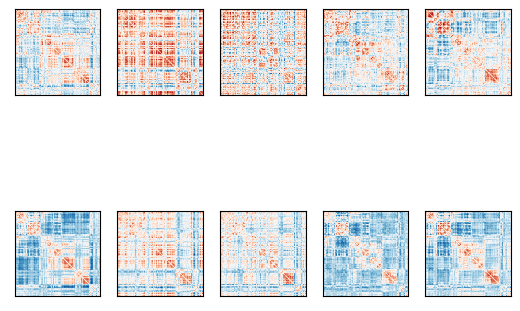

In [16]:
# visualize predicted vs. original matrix
#decoded_matrix = selected_decoder.predict(X_train)
random_idx = random.sample(range(decoded_matrix.shape[0]),5)
for i,r in enumerate(random_idx):
    mat_original = X_all[r].reshape(128, 128)
    mat_decoded = decoded_matrix[r].reshape(128,128)
    np.fill_diagonal(mat_original, 0)
    np.fill_diagonal(mat_decoded, 0)
    mat_original_reorder = mat_original[sorted_indices][:, sorted_indices]
    mat_decoded_reorder = mat_decoded[sorted_indices][:, sorted_indices]

    ax = plt.subplot(2, 5, i+1)
    plt.imshow(mat_original_reorder,cmap = 'RdBu_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed images
    ax = plt.subplot(2, 5, i+1+5)
    plt.imshow(mat_decoded_reorder,cmap = 'RdBu_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    print(r)

plt.show()

## Visualize the latent representation

In [18]:
# apply the selected model to the data

for idx, layer in enumerate(selected_decoder.layers):
    print(f"Layer {idx}: {layer.name}, Output Shape: {layer.output_shape}")
    
encoder_model = Model(inputs=selected_decoder.input, outputs=selected_decoder.layers[4].output)

# Get latent features using the encoder model
print('******************************************')
latent_features_all = encoder_model.predict(X_all)
print(latent_features_all.shape)

Layer 0: input_1, Output Shape: [(None, 16384)]
Layer 1: dense, Output Shape: (None, 4096)
Layer 2: dense_1, Output Shape: (None, 1024)
Layer 3: dense_2, Output Shape: (None, 256)
Layer 4: dense_3, Output Shape: (None, 32)
Layer 5: dense_4, Output Shape: (None, 256)
Layer 6: dense_5, Output Shape: (None, 1024)
Layer 7: dense_6, Output Shape: (None, 4096)
Layer 8: dense_7, Output Shape: (None, 16384)
******************************************
21/21 [==============================] - 1s 31ms/step
(648, 32)


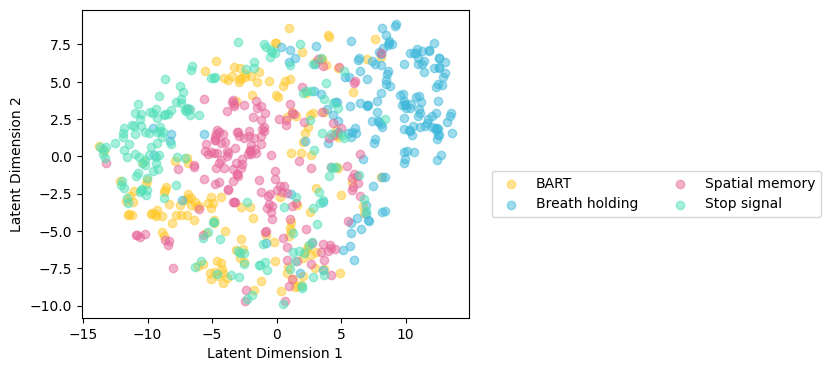

In [41]:
# Visualize the latent space using t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
latent_tsne = tsne.fit_transform(latent_features_all)
c_list = ['#ffc92bff','#3fb9dbff','#e7679aff','#4fe0b9ff']
task_name = ['BART','Breath holding','Spatial memory','Stop signal']
plt.figure(figsize=(5, 4))
for i,task in enumerate(task_list):
    data_x = latent_tsne[np.where(y_all == task)[0], 0]
    data_y = latent_tsne[np.where(y_all == task)[0],1]
    plt.scatter(data_x, data_y, c=c_list[i], alpha=0.5, label = task_name[i])

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left",
                ncol=2)
plt.show()


In [24]:
np.where(y_all == task)[0]

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152,
       156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204,
       208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256,
       260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308,
       312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360,
       364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412,
       416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464,
       468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516,
       520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568,
       572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620,
       624, 628, 632, 636, 640, 644])

## Save the output for DNN

In [25]:
file_path = 'latent_features_all.npy'
np.save(file_path, latent_features_all)
file_path2 = 'labels.npy'
np.save(file_path2, y_all)


In [28]:
latent_features_all.shape

(648, 32)